<center><h4> This data-challenge was created for the data-camp course of the Master 2 Data-Science of Université Évry (Paris-Saclay) </h4></center>

# Introduction 

Biologically, [it is known that](https://www.ncbi.nlm.nih.gov/books/NBK26885/), while cells carry (almost) the same genomic information, they tend to *express* only a fraction of their genes leading to specialization into specific *types* with different biological functions. Thus, cell-types study and classification is of primary interest for many biological and medical applications. In the past decade, measuring genes expression level at the scale of a unique cell has become possible with the rise of high-throughput technologies named single-cell RNA-seq (scRNA-seq).

The goal of this data challenge is the **supervised** classification of cell-types thanks to the **scMARK** benchmark dataset from [Mendonca et. al](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1). The authors compiled 100, 000 cells expression from 10 different studies to serve as a comparison for different machine learning approaches, in an analogy with the MNIST benchmark dataset for computer vision. 

This data-challenge uses a small extraction with only 4 cell-types (the labels to predict) from **scMARK**:

    1. Cancer_cells
    2. NK_cells
    3. T_cells_CD4+
    4. T_cells_CD8+
    
The public dataset contains 1500 points splitted in 1000 training points and 500 test points. It will serve as your local benchmark for developing your submissions. On the server side, your submission will use the whole 1500 public points as the training set, and another **private and unavailable test** dataset, containing 1500 supplementary test points, will be used for the ranking of participants. The labels' distribution in the public (resp. private) training and testing datasets are the same.

# Setup 

If marked as `code`, the two following cells will 

* install the required package dependencies
* download the public data on OSF

They are disabled by default since you only have to call these command once (in your dedicated Python env). You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from problem import get_train_data, get_test_data
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

The Data

In [2]:

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [3]:
X_train.toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### A first look at the data


In [4]:
total_genes_counts = X_train.toarray().sum(axis=0)
total_cell_counts = X_train.toarray().sum(axis=1)

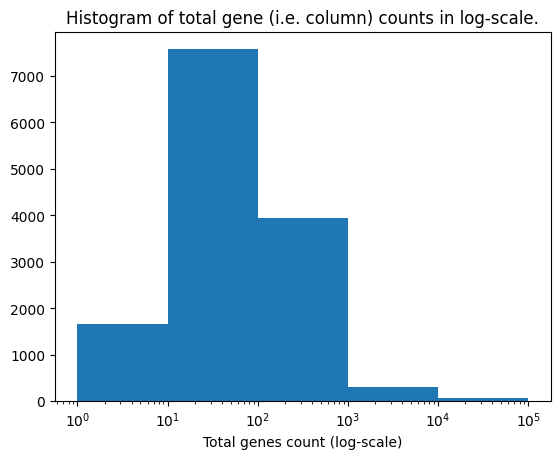

In [5]:
# plt.hist(np.log10(total_genes_counts), bins = np.arange(6))
plt.hist(total_genes_counts, bins = 10**np.arange(6))
plt.xscale("log")
plt.title("Histogram of total gene (i.e. column) counts in log-scale.")
plt.xlabel('Total genes count (log-scale)')
plt.show()

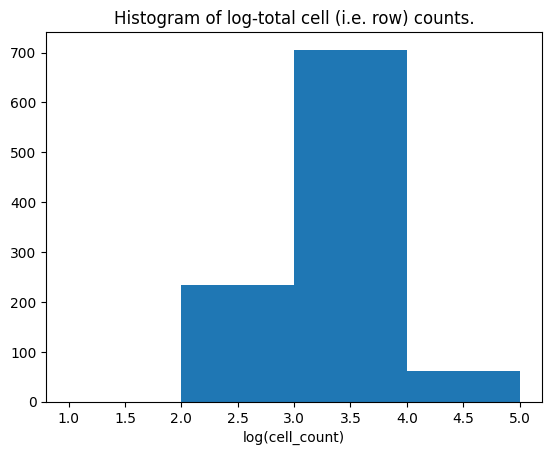

In [6]:
plt.hist(np.log10(total_cell_counts), bins = np.arange(1,6))
plt.title("Histogram of log-total cell (i.e. row) counts.")
plt.xlabel('log(cell_count)')
plt.show()

In [7]:
# Convert to DataFrame
x_train = pd.DataFrame(X_train.toarray())
x_test = pd.DataFrame(X_test.toarray())
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,13541,13542,13543,13544,13545,13546,13547,13548,13549,13550
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
classes = y_train.categories
print(classes)
annotation ={} 
for i, cls in enumerate(classes):
    annotation[i] = cls
print(annotation)

Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object')
{0: 'Cancer_cells', 1: 'NK_cells', 2: 'T_cells_CD4+', 3: 'T_cells_CD8+'}


0. Cancer_cells
1. NK_cells
2. T_cells_CD4+
3. T_cells_CD8+


In [9]:
# Annotation des classes
y_train_encoded = y_train.codes
y_test_encoded = y_test.codes
y_train = pd.Series(y_train_encoded)
y_test = pd.Series(y_test_encoded)

y_train.head()

0    2
1    2
2    2
3    2
4    3
dtype: int8

{'classes': Index(['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+'], dtype='object'), 'occurrences': 3    342
2    336
0    237
1     85
Name: count, dtype: int64}


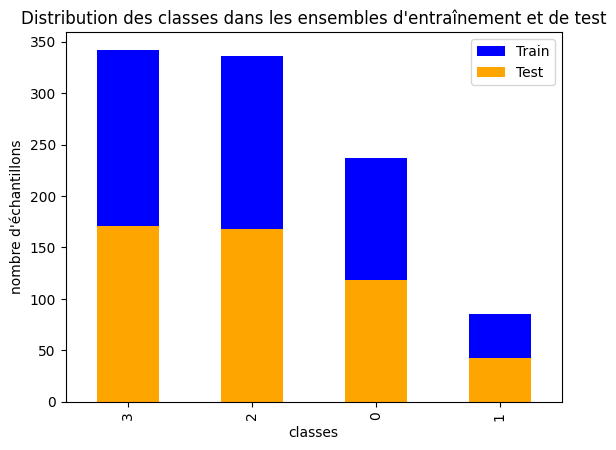

In [10]:
# Exploration des données

## Distribution des classes 
Occurence_train = {}
Occurence_train["classes"] = classes
Occurence_train["occurrences"] = y_train.value_counts()
print(Occurence_train)

y_train.value_counts().plot(kind='bar', color='blue')
y_test.value_counts().plot(kind='bar', color='orange')
plt.xlabel('classes')
plt.ylabel('nombre d\'échantillons')
plt.title('Distribution des classes dans les ensembles d\'entraînement et de test')
plt.legend(['Train','Test'])


Mon premier essai était d'explorer les données et d'essayer de savoir les gènes importantes pour chaque cellule. Le problème c'est que j'ai fait l'exploration sans normalization et jugé que la moitié des gènes ne sont pas assez représentatives pour la majorité des cellules. Les résultats sont dans les diagrammes au-dessous. 
L'idée derrière est aussi le fait d'ajouter des données pour les la classes 1 en se basant sur la distribution de chaque gène dans les cellules détectées cell_1. 

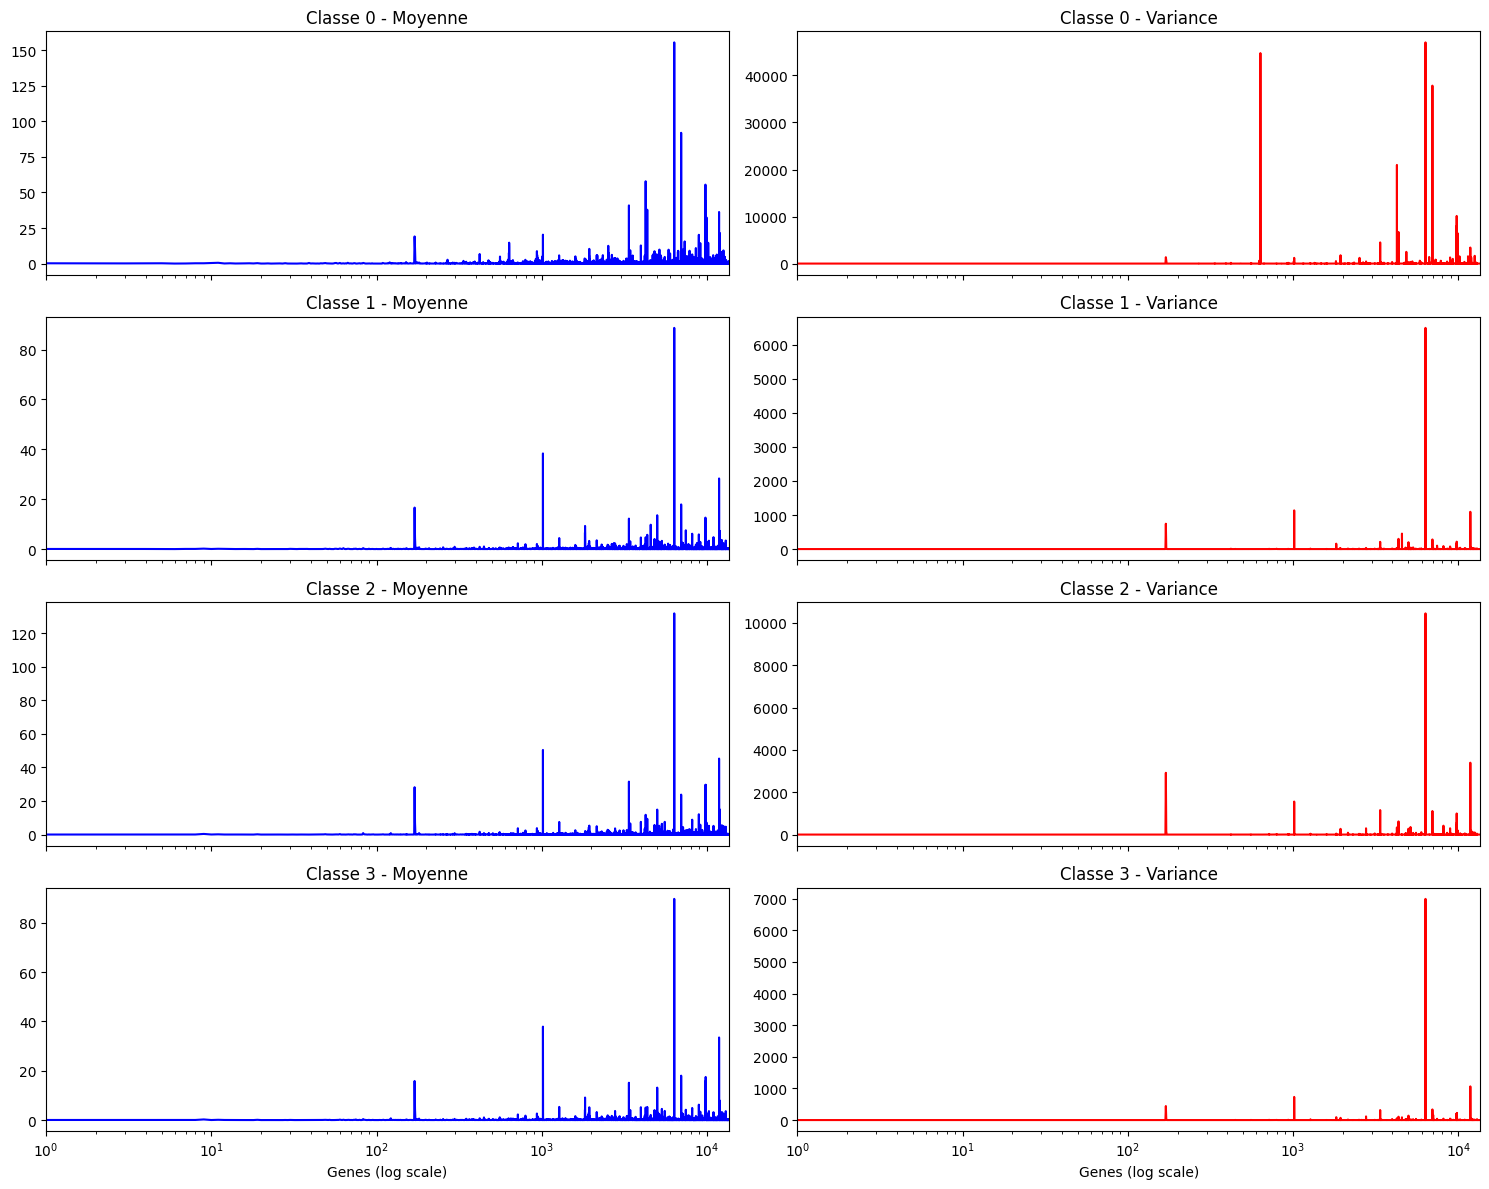

In [11]:
classes = np.unique(y_train)
n_classes = len(classes)
n_genes = X_train.shape[1]

fig, axes = plt.subplots(n_classes, 2, figsize=(15, 3*n_classes), sharex=True)

for idx, cls in enumerate(classes):
    gene_values = X_train[y_train == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convertir sparse -> dense si nécessaire
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    # Moyenne et variance par gène
    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    # Plot moyenne
    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes])

    # Plot variance
    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes])

# Label commun pour l'axe des x
for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()


A partir des digrammes précedants, on remarque qu'environ la moitié  des gènes ( de 0 à 10^2) ne sont pas assez représntatives pour toutes les classes. 
Nous procédons à la suppression des gènes les moins representatifs

In [12]:
import numpy as np
from scipy.sparse import issparse

def remove_genes(X, threshold=0.2):
    """
    Supprime les gènes dont la variance est inférieure à un seuil.

    Args:
        X (np.ndarray ou csr_matrix): matrice cellules x gènes
        threshold (float): seuil minimal de variance

    Returns:
        X_filtered: matrice filtrée (mêmes type que X)
        kept_idx: indices des gènes conservés
    """
    if issparse(X):
        # variance = mean(x^2) - mean(x)^2
        mean = np.array(X.mean(axis=0)).ravel()
        mean_sq = np.array(X.multiply(X).mean(axis=0)).ravel()
        var = mean_sq - mean**2
    else:
        var = X.var(axis=0)

    # indices des gènes à garder
    kept_idx = np.where(var >= threshold)[0]

    # filtrer X
    if issparse(X):
        X_filtered = X[:, kept_idx]
    else:
        X_filtered = X[:, kept_idx]

    return X_filtered, kept_idx
X_train, kept_genes_idx = remove_genes(X_train, threshold=0.01)

**Normalisation**
Maintenant je vais essayer de normaliser les données de x_train et les nommer x_train_normalized.

La question qui se pose: pourquoi appliquer une normalisation ? 
 
 - *Correction de la profondeur de séquençage* : Chaque échantillon peut avoir un nombre total de lectures très différent. Sans normalisation, les différences reflètent surtout la quantité totale de séquençage et non l’expression réelle.
 - *Stabilisation de la variance* : Les gènes peu exprimés ont une variance très élevée relative à leur moyenne. Les gènes très exprimés dominent les analyses multivariées (PCA, clustering).
 - *Comparabilité entre échantillons* : Permet de comparer les niveaux d’expression entre échantillons et conditions.

 


In [13]:
import numpy as np



def preprocess_X(X, method=None):
    """
    Preprocess an RNA-seq expression matrix.
    
    Parameters
    ----------
    X : np.ndarray or scipy.sparse matrix
        Input expression matrix (cells x genes)
    method : str or None
        Type of normalization:
        - None : return X as is
        - "log" : log1p transform
        - "library_size" : normalize each cell by total counts (library size) then log1p
    
    Returns
    -------
    X_processed : np.ndarray
        Preprocessed expression matrix
    """
    # Convert sparse to dense if needed
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    X_processed = X.copy()
    
    if method is None:
        return X_processed
    
    if method == "simple_normalize":
        return X / X.sum(axis=1)[:, np.newaxis]
    
    elif method == "log":
        X_processed = np.log1p(X_processed)
        return X_processed
    
    elif method == "library_size":
        # compute total counts per cell
        library_size = X_processed.sum(axis=1)[:, None]
        # avoid division by zero
        library_size[library_size == 0] = 1
        # normalize
        X_processed = X_processed / library_size * 1e4
        # log1p transform
        X_processed = np.log1p(X_processed)
        return X_processed
    
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")

preprocessing_method = "library_size"
X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)


Niveau d'expression des gènes

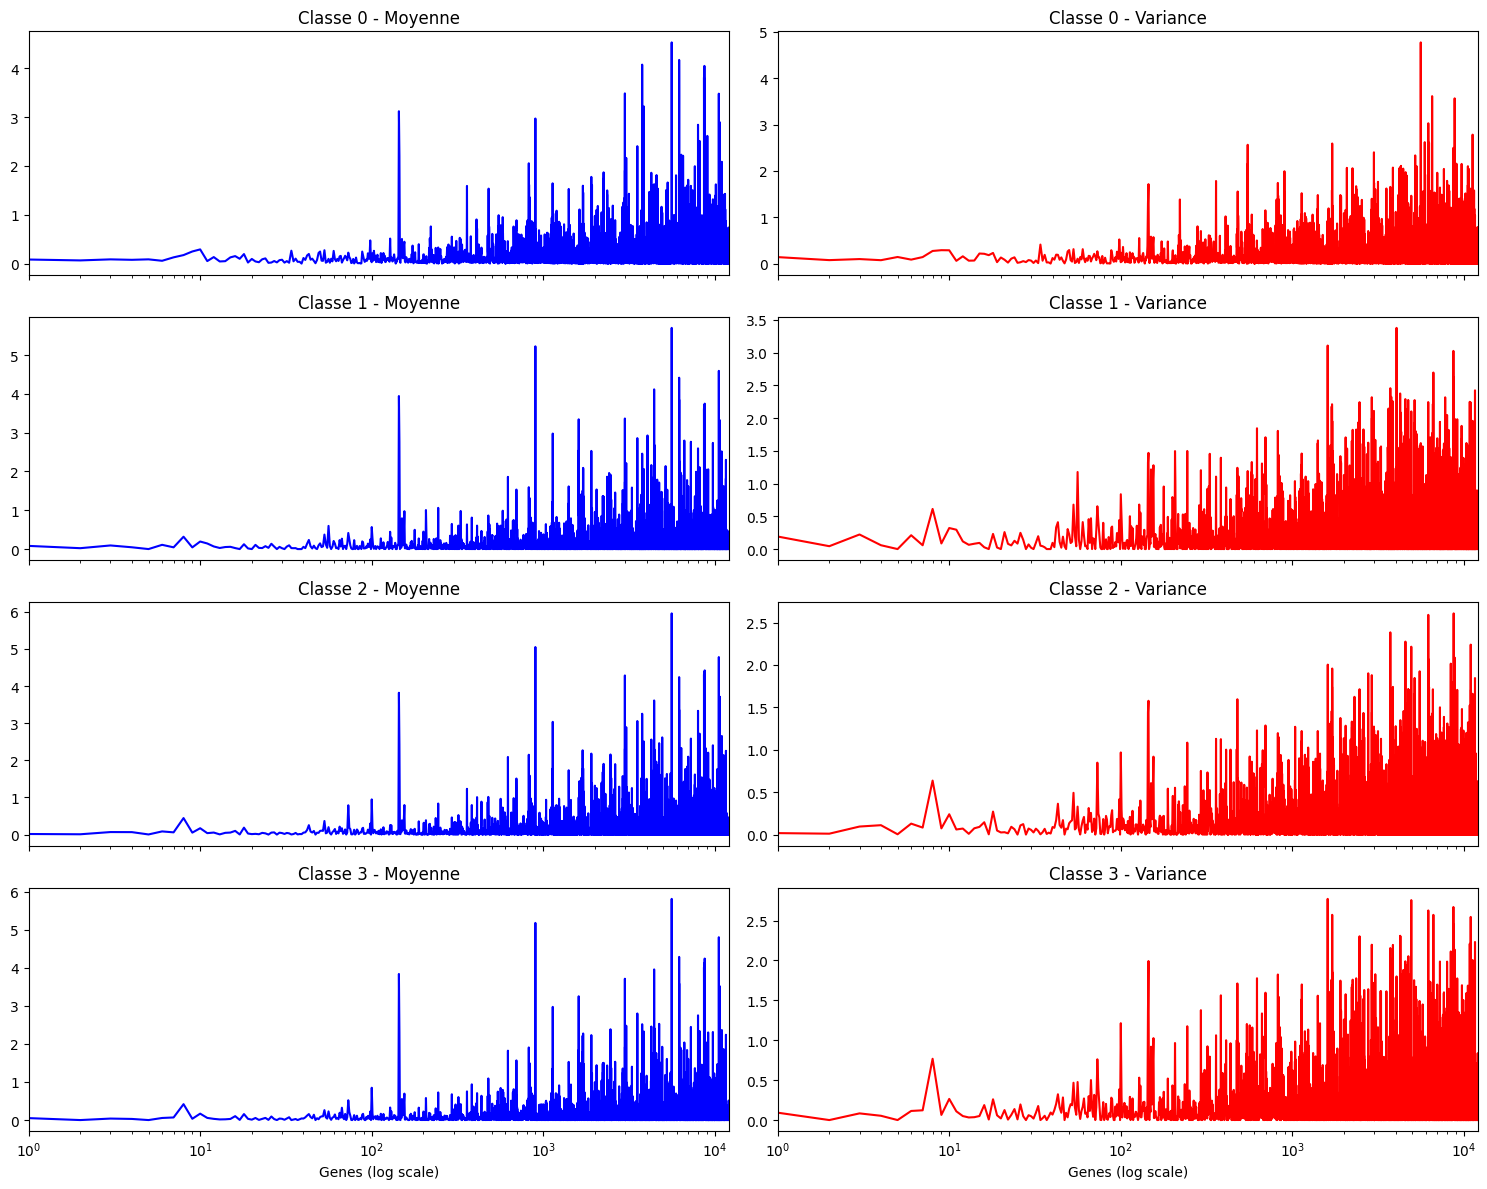

In [14]:
import numpy as np

import matplotlib.pyplot as plt

# Assuming X_train_norm and y_train are available from previous cells
classes = np.unique(y_train)
n_classes = len(classes)
n_genes = X_train_norm.shape[1]

fig, axes = plt.subplots(n_classes, 2, figsize=(15, 3*n_classes), sharex=True)

for idx, cls in enumerate(classes):
    gene_values = X_train_norm[y_train == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convertir sparse -> dense si nécessaire
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    # Moyenne et variance par gène
    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    # Plot moyenne
    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes])

    # Plot variance
    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes])

# Label commun pour l'axe des x
for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()

# ACP

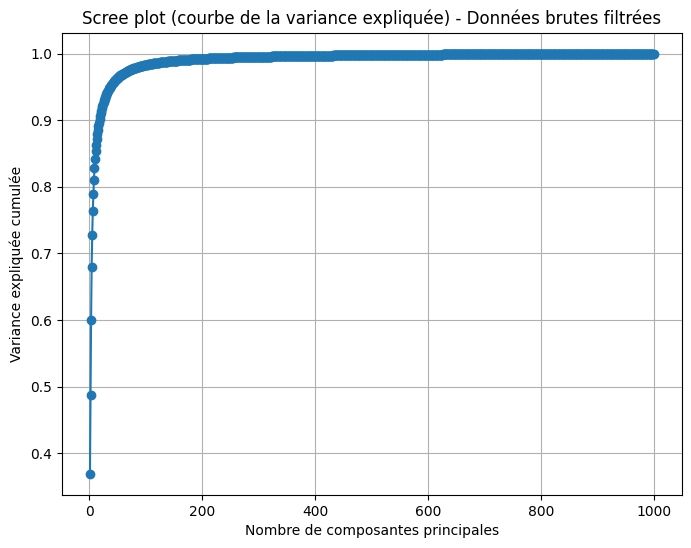

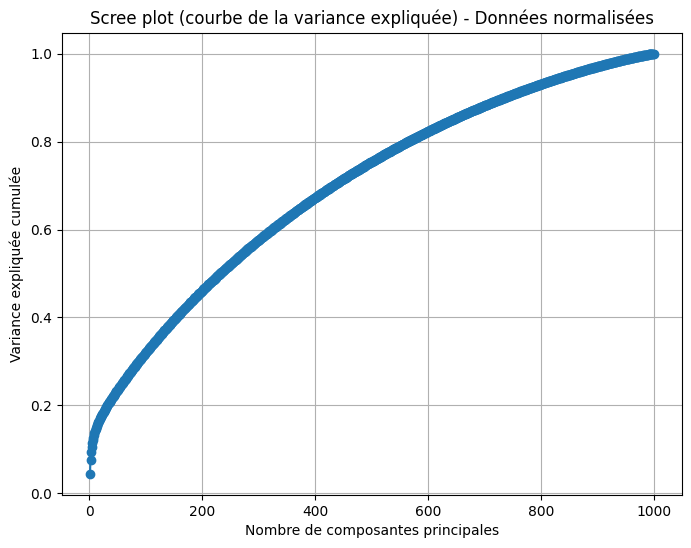

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_scree_plot(X, title_suffix=""):
    """
    Plot the scree plot for PCA on the given data matrix X.
    
    Parameters
    ----------
    X : array-like
        Input data matrix
    title_suffix : str
        Suffix to add to the plot title
    """
    pca = PCA().fit(X)
    explained_variance_cumsum = pca.explained_variance_ratio_.cumsum()
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance_cumsum) + 1), 
             explained_variance_cumsum, marker='o', linestyle='-')
    plt.xlabel('Nombre de composantes principales')
    plt.ylabel('Variance expliquée cumulée')
    plt.title(f'Scree plot (courbe de la variance expliquée){title_suffix}')
    plt.grid(True)
    plt.show()

# Scree plot for raw filtered data
plot_scree_plot(X_train, " - Données brutes filtrées")

# Scree plot for normalized data
plot_scree_plot(X_train_norm, " - Données normalisées")

# Implémentation des models

##  0. Constitution du jeu de test


In [16]:
X_test = X_test[:, kept_genes_idx]
X_test_norm = preprocess_X(X_test, method=preprocessing_method)

## 1. Random Forest

In [17]:



random_forest_pipe = Pipeline(
    [
        #("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 60 components", PCA(n_components=60)),
        (
            "Random Forest Classifier",
            RandomForestClassifier(
                max_depth=75, n_estimators=200, max_features=15
            ),
        ),
    ]
)

random_forest_pipe

Pipeline(steps=[('PCA with 60 components', PCA(n_components=60)),
                ('Random Forest Classifier',
                 RandomForestClassifier(max_depth=75, max_features=15,
                                        n_estimators=200))])

In [18]:
# fit on train
pipe = random_forest_pipe
pipe.fit(X_train_norm, y_train)
y_tr_pred_random = pipe.predict(X_train_norm)

# predict on test


y_te_pred_random = pipe.predict(X_test_norm)

Train balanced accuracy : 1.000
Test balanced accuracy : 0.752


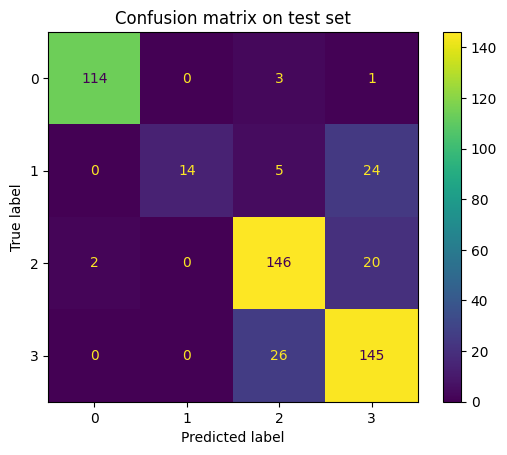

In [19]:


# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred_random):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred_random):.3f}")
cm = confusion_matrix(y_test, y_te_pred_random)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

## 2. LinearSVC

In [20]:


# Create a Linear SVC pipeline
linear_svc_pipe = Pipeline(
    [
        ("PCA", PCA(n_components=60)),
        ("Linear SVC", LinearSVC(max_iter=200000, random_state=42)),
    ]
)
linear_svc_pipe


Pipeline(steps=[('PCA', PCA(n_components=60)),
                ('Linear SVC', LinearSVC(max_iter=200000, random_state=42))])

In [21]:
# fit on train
pipe = linear_svc_pipe
pipe.fit(X_train_norm, y_train)
y_tr_pred_svc = pipe.predict(X_train_norm)

# predict on test


y_te_pred_svc = pipe.predict(X_test_norm)


Train balanced accuracy : 0.900
Test balanced accuracy : 0.810


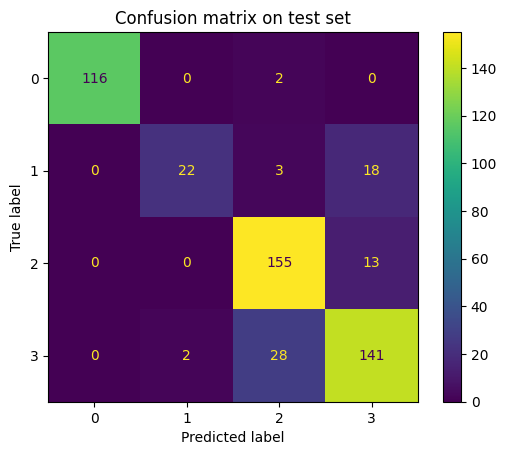

In [22]:
# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred_svc):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred_svc):.3f}")
cm = confusion_matrix(y_test, y_te_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

## KNeighbors classifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Build pipeline: reduce dimensionality then KNN
knn_pipe = Pipeline([
    ("PCA", PCA(n_components=60)),
    ("KNN", KNeighborsClassifier(n_neighbors=20, n_jobs=-1)),
])

knn_pipe

Pipeline(steps=[('PCA', PCA(n_components=60)),
                ('KNN', KNeighborsClassifier(n_jobs=-1, n_neighbors=20))])

Train balanced accuracy : 0.762
Test balanced accuracy : 0.679


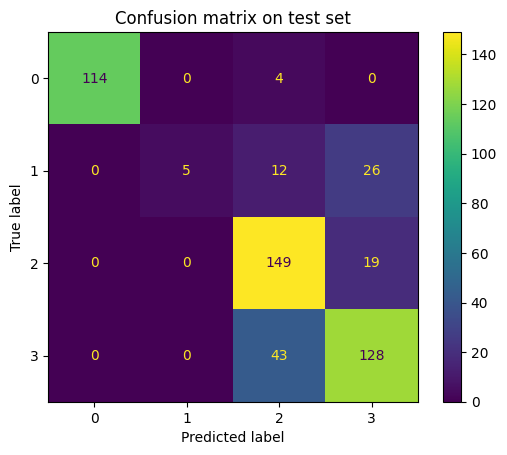

In [25]:
# fit the KNN pipeline
knn_pipe.fit(X_train_norm, y_train)

# compute balanced accuracy and confusion matrix
y_tr_pred_knn = knn_pipe.predict(X_train_norm)
y_te_pred_knn = knn_pipe.predict(X_test_norm)
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred_knn):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred_knn):.3f}")
cm = confusion_matrix(y_test, y_te_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.811


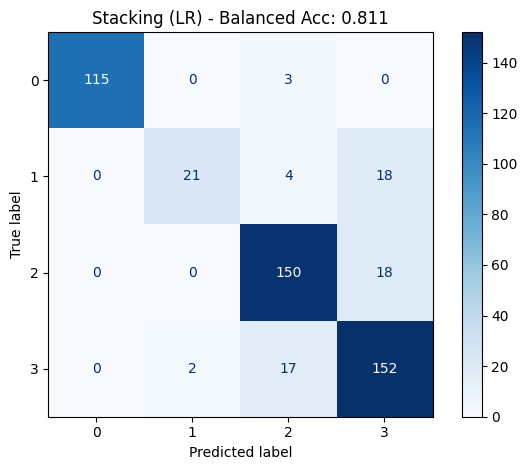

In [26]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Ensemble classifiers (Voting + Stacking) on PCA-reduced features
# Relies on existing notebook variables: X_train_norm, X_test_norm, y_train, y_test

import matplotlib.pyplot as plt

def fit_eval_ensembles(X_train, X_test, y_train, y_test, pca_n_components=60, random_state=42):
    # encode labels to integers for stacking final estimator
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    # PCA reduction
    pca = PCA(n_components=min(pca_n_components, np.asarray(X_train).shape[1]), random_state=random_state)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # base estimators
    rf = RandomForestClassifier(n_estimators=200, max_depth=50, max_features="sqrt", random_state=random_state)
    svc = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=random_state)
    knn = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)

    # Voting (soft) ensemble
    voting = VotingClassifier(
        estimators=[("rf", rf), ("svc", svc), ("knn", knn)],
        voting="soft",
        n_jobs=-1,
    )

    # Stacking ensemble (uses same base estimators)
    stacking = StackingClassifier(
        estimators=[("rf", rf), ("svc", svc), ("knn", knn)],
        final_estimator=LogisticRegression(max_iter=2000, solver="lbfgs"),
        n_jobs=-1,
        passthrough=False,
    )

    ensembles = {
        #"Voting (soft)": voting, 
        "Stacking (LR)": stacking}

    results = {}
    for name, clf in ensembles.items():
        print(f"Fitting {name} ...")
        clf.fit(X_train_pca, y_train_enc)
        y_pred_enc = clf.predict(X_test_pca)
        y_pred = le.inverse_transform(y_pred_enc)
        bal = balanced_accuracy_score(y_test, y_pred)
        results[name] = {"bal_acc": bal, "clf": clf, "y_pred": y_pred}
        print(f"{name} balanced accuracy: {bal:.3f}")

        # confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
        disp.plot(cmap="Blues", values_format='d')
        plt.title(f"{name} - Balanced Acc: {bal:.3f}")
        plt.tight_layout()
        plt.show()

    return results, pca, le

# Run ensembles (uses X_train_norm / X_test_norm already defined in the notebook)
results, pca_model_ens, label_encoder_ens = fit_eval_ensembles(
    X_train_norm, X_test_norm, y_train, y_test, pca_n_components=60
)

# Approche: Prédiction en deux etapes

## Adaptation du dataset, merge des classes 1 et 3

Nous entrainons le modèle sur 3 classes.

In [73]:
#reload the data and preprocess
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [77]:
#normalize the data

X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)

X_train_norm_merged = X_train_norm.copy()
X_test_norm_merged = X_test_norm.copy()

# merge classes 1 and 3 (NK_cells and T_cells_CD8+ according to current categories)
merge_from = {"NK_cells", "T_cells_CD8+"}
new_label = "NK_or_T_cells_CD8+"

# convert categorical labels to string arrays and replace
# Use the annotation dict to map codes to names
y_train_arr = np.array([annotation[code] for code in y_train.codes])
y_test_arr = np.array([annotation[code] for code in y_test.codes])

y_train_merged = y_train_arr.copy()
y_train_merged[np.isin(y_train_merged, list(merge_from))] = new_label

y_test_merged = y_test_arr.copy()
y_test_merged[np.isin(y_test_merged, list(merge_from))] = new_label

# convert back to pandas Categorical (keep behavior similar to original y variables)
y_train_merged = pd.Categorical(y_train_merged)
y_test_merged = pd.Categorical(y_test_merged)

# quick check
print("Train label distribution:\n", pd.Series(y_train_merged).value_counts())
print("Test label distribution:\n", pd.Series(y_test_merged).value_counts())

Train label distribution:
 NK_or_T_cell    427
T_cells_CD4+    336
Cancer_cells    237
Name: count, dtype: int64
Test label distribution:
 NK_or_T_cell    214
T_cells_CD4+    168
Cancer_cells    118
Name: count, dtype: int64


Nous testons plusieurs valeurs de pca_n_components, pour avoir le meilleur paramètre

In [ ]:
X_train_merged_filtered, kept_genes_bin_idx = remove_genes(X_train_norm_merged, threshold=0.2)
X_test_bin_filtered = X_test_norm_merged[:, kept_genes_bin_idx]

Filtered X_train_merged shape: (1000, 258)
Filtered X_test_merged shape: (500, 258)
Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.928


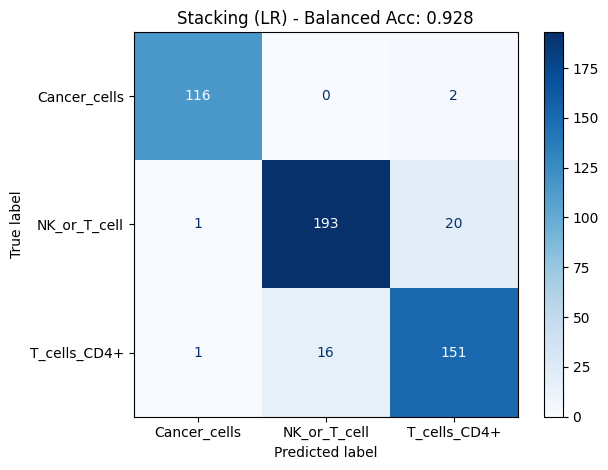

In [97]:
# Filtrage des gènes pour le modèle merged avec threshold=0.2
X_train_merged_filtered, kept_genes_merged_idx = remove_genes(X_train_norm_merged, threshold=1.2)
X_test_merged_filtered = X_test_norm_merged[:, kept_genes_merged_idx]

print(f"Filtered X_train_merged shape: {X_train_merged_filtered.shape}")
print(f"Filtered X_test_merged shape: {X_test_merged_filtered.shape}")

# Entraînement du modèle merged sur les données filtrées
results_merge, pca_model_merge, label_encoder_merge = fit_eval_ensembles(
    X_train_merged_filtered, X_test_merged_filtered, y_train_merged, y_test_merged, pca_n_components=60
)

## Modèle de prediction des classes {"NK_cells", "T_cells_CD8+"}

In [80]:
#reload the data and preprocess
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

#normalize the data

X_train_norm = preprocess_X(X_train, method=preprocessing_method)
X_test_norm = preprocess_X(X_test, method=preprocessing_method)

# Create new copies of normalized feature matrices
X_train_norm_binary = X_train_norm.copy()
X_test_norm_binary = X_test_norm.copy()

# Only conserve NK_cells and T_cells_CD8+ in train/test labels
binary_classes = {"NK_cells", "T_cells_CD8+"}

# Convert categorical labels to string arrays
y_train_arr_bin = np.array(y_train).astype(str).copy()
y_test_arr_bin = np.array(y_test).astype(str).copy()

# Filter indices for binary classification
train_idx_bin = np.isin(y_train_arr_bin, list(binary_classes))
test_idx_bin = np.isin(y_test_arr_bin, list(binary_classes))

# Filter features and labels
X_train_norm_bin = X_train_norm_binary[train_idx_bin]
X_test_norm_bin = X_test_norm_binary[test_idx_bin]
y_train_bin = y_train_arr_bin[train_idx_bin]
y_test_bin = y_test_arr_bin[test_idx_bin]

# Convert to pandas Categorical for compatibility
y_train_bin = pd.Categorical(y_train_bin)
y_test_bin = pd.Categorical(y_test_bin)

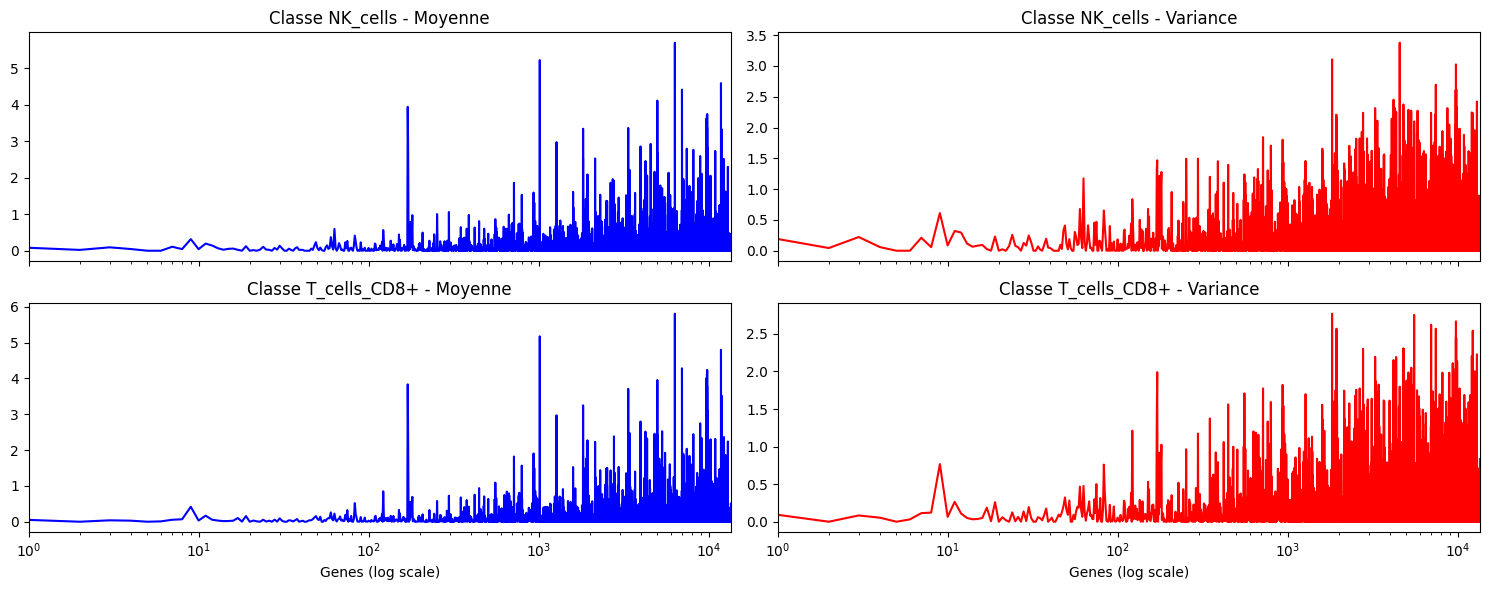

In [60]:


import numpy as np
import matplotlib.pyplot as plt

binary_classes = np.unique(y_train_bin)
n_classes_bin = len(binary_classes)
n_genes_bin = X_train_norm_bin.shape[1]

fig, axes = plt.subplots(n_classes_bin, 2, figsize=(15, 3 * n_classes_bin), sharex=True)

for idx, cls in enumerate(binary_classes):
    gene_values = X_train_norm_bin[np.array(y_train_bin) == cls]

    if gene_values.shape[0] == 0:
        print(f"Classe {cls} vide, skipping")
        continue

    # Convert sparse -> dense if needed
    if hasattr(gene_values, "toarray"):
        gene_values = gene_values.toarray()

    mean = np.nan_to_num(gene_values.mean(axis=0))
    var = np.nan_to_num(gene_values.var(axis=0))

    axes[idx, 0].plot(mean, color='blue')
    axes[idx, 0].set_title(f"Classe {cls} - Moyenne")
    axes[idx, 0].set_xscale('log')
    axes[idx, 0].set_xlim([1, n_genes_bin])

    axes[idx, 1].plot(var, color='red')
    axes[idx, 1].set_title(f"Classe {cls} - Variance")
    axes[idx, 1].set_xscale('log')
    axes[idx, 1].set_xlim([1, n_genes_bin])

for ax in axes[-1, :]:
    ax.set_xlabel("Genes (log scale)")

plt.tight_layout()
plt.show()



We keep only high expressed genes

In [81]:
from scipy.sparse import issparse

# Remove low expressed genes using variance threshold 0.2

X_train_bin_filtered, kept_genes_bin_idx = remove_genes(X_train_norm_bin, threshold=0.8)
X_test_bin_filtered = X_test_norm_bin[:, kept_genes_bin_idx]

print(f"Filtered X_train_bin shape: {X_train_bin_filtered.shape}")
print(f"Filtered X_test_bin shape: {X_test_bin_filtered.shape}")

Filtered X_train_bin shape: (427, 616)
Filtered X_test_bin shape: (214, 616)


Fitting Stacking (LR) ...
Stacking (LR) balanced accuracy: 0.860


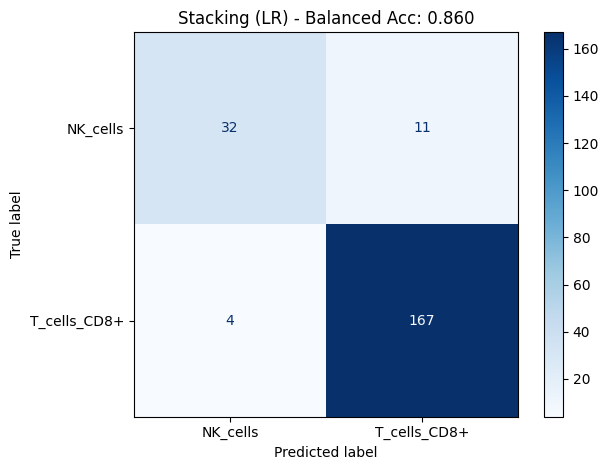

In [82]:

# Train and predict using the previous ensemble function
results_bin, pca_model_bin, label_encoder_bin = fit_eval_ensembles(
    X_train_bin_filtered, X_test_bin_filtered, y_train_bin, y_test_bin, pca_n_components=0.8
)

## Combinaison des deux modèles

## Designing the RAMP submission


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.sparse import issparse


def remove_genes(X, threshold=0.01):
    """
    Supprime les gènes dont la variance est inférieure à un seuil.

    Args:
        X (np.ndarray ou csr_matrix): matrice cellules x gènes
        threshold (float): seuil minimal de variance

    Returns:
        X_filtered: matrice filtrée (mêmes type que X)
        kept_idx: indices des gènes conservés
    """
    if issparse(X):
        # variance = mean(x^2) - mean(x)^2
        mean = np.array(X.mean(axis=0)).ravel()
        mean_sq = np.array(X.multiply(X).mean(axis=0)).ravel()
        var = mean_sq - mean**2
    else:
        var = X.var(axis=0)

    # indices des gènes à garder
    kept_idx = np.where(var >= threshold)[0]

    # filtrer X
    if issparse(X):
        X_filtered = X[:, kept_idx]
    else:
        X_filtered = X[:, kept_idx]

    return X_filtered, kept_idx


class Classifier(object):
    def __init__(self):
        # Label encoders for both stages
        self.le_merge = LabelEncoder()  # For 3-class merged model
        self.le_bin = LabelEncoder()    # For binary NK/T-CD8+ model
        
        # Gene filtering indices
        self.kept_idx_merge = None  # For merged model
        self.kept_idx_bin = None    # For binary model
        
        # Stage 1: Merged model (3 classes: B_cells, Monocytes, NK_or_T_cell)
        rf_merge = RandomForestClassifier(n_estimators=200, max_depth=50,
                                         max_features="sqrt", random_state=42)
        svc_merge = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale",
                       random_state=42)
        knn_merge = KNeighborsClassifier(n_neighbors=15)
        
        stack_merge = StackingClassifier(
            estimators=[("rf", rf_merge), ("svc", svc_merge), ("knn", knn_merge)],
            final_estimator=LogisticRegression(max_iter=10000, solver="lbfgs"),
            n_jobs=-1,
            passthrough=False
        )
        
        self.pipe_merge = make_pipeline(
            PCA(n_components=60, random_state=42),
            stack_merge
        )
        
        # Stage 2: Binary model (NK_cells vs T_cells_CD8+)
        rf_bin = RandomForestClassifier(n_estimators=200, max_depth=50,
                                       max_features="sqrt", random_state=42)
        svc_bin = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale",
                     random_state=42)
        knn_bin = KNeighborsClassifier(n_neighbors=15)
        
        stack_bin = StackingClassifier(
            estimators=[("rf", rf_bin), ("svc", svc_bin), ("knn", knn_bin)],
            final_estimator=LogisticRegression(max_iter=10000, solver="lbfgs"),
            n_jobs=-1,
            passthrough=False
        )
        
        self.pipe_bin = make_pipeline(
            PCA(n_components=0.8, random_state=42),  # 80% variance
            stack_bin
        )

    def _preprocess_X(self, X, fit=False, kept_idx=None, threshold=0.01):
        """
        Preprocess features: filter genes + library size normalization + log1p
        """
        # Convert sparse to dense if needed
        if issparse(X):
            X = X.toarray()
        
        # Gene filtering
        if fit:
            X_filtered, kept_idx = remove_genes(X, threshold=threshold)
            return_idx = kept_idx
        else:
            if kept_idx is None:
                raise ValueError("kept_idx must be provided when fit=False")
            X_filtered = X[:, kept_idx]
            return_idx = None
        
        # Library size normalization + log1p
        libsize = X_filtered.sum(axis=1)[:, None]
        libsize[libsize == 0] = 1
        X_processed = np.log1p(X_filtered / libsize * 1e4)
        
        if fit:
            return X_processed, return_idx
        else:
            return X_processed

    def fit(self, X_sparse, y):
        """
        Train the two-stage classifier
        
        Stage 1: Train merged model (3 classes)
        Stage 2: Train binary model (NK_cells vs T_cells_CD8+)
        """
        # Convert y to numpy array
        y_arr = np.array(y).astype(str)
        
        # ===== STAGE 1: Merged Model (3 classes) =====
        # Merge NK_cells and T_cells_CD8+ into one class
        merge_from = {"NK_cells", "T_cells_CD8+"}
        self.merged_label = "NK_or_T_cell"  # Store the merged label name
        
        y_merged = y_arr.copy()
        y_merged[np.isin(y_merged, list(merge_from))] = self.merged_label
        
        # Preprocess and fit merged model
        X_merge, self.kept_idx_merge = self._preprocess_X(X_sparse, fit=True, threshold=1.2)
        y_merge_enc = self.le_merge.fit_transform(y_merged)
        self.pipe_merge.fit(X_merge, y_merge_enc)
        
        # ===== STAGE 2: Binary Model (NK_cells vs T_cells_CD8+) =====
        # Filter to only NK_cells and T_cells_CD8+
        binary_classes = {"NK_cells", "T_cells_CD8+"}
        bin_mask = np.isin(y_arr, list(binary_classes))
        
        X_bin = X_sparse[bin_mask] if issparse(X_sparse) else X_sparse[bin_mask]
        y_bin = y_arr[bin_mask]
        
        # Preprocess with higher variance threshold for binary model
        X_bin_processed, self.kept_idx_bin = self._preprocess_X(X_bin, fit=True, threshold=0.8)
        y_bin_enc = self.le_bin.fit_transform(y_bin)
        self.pipe_bin.fit(X_bin_processed, y_bin_enc)
        
        # Store original classes for compatibility
        self.classes_ = np.unique(y_arr)
        
        # Create mapping from class names to indices
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes_)}

    def predict_proba(self, X_sparse):
        """
        Two-stage prediction:
        1. Predict with merged model (3 classes)
        2. If predicted as NK_or_T_cell, refine with binary model
        """
        n_samples = X_sparse.shape[0]
        n_classes = len(self.classes_)
        
        # Initialize probability matrix
        proba_final = np.zeros((n_samples, n_classes))
        
        # ===== STAGE 1: Predict with merged model =====
        X_merge = self._preprocess_X(X_sparse, fit=False, kept_idx=self.kept_idx_merge)
        proba_merge = self.pipe_merge.predict_proba(X_merge)
        y_pred_merge_enc = self.pipe_merge.predict(X_merge)
        y_pred_merge = self.le_merge.inverse_transform(y_pred_merge_enc)
        
        # ===== STAGE 2: Process predictions =====
        nk_or_t_mask = y_pred_merge == self.merged_label
        
        # For samples NOT predicted as merged class
        for i in np.where(~nk_or_t_mask)[0]:
            pred_label = y_pred_merge[i]
            class_idx = self.class_to_idx[pred_label]
            # Use probabilities from merged model
            merge_class_idx = self.le_merge.transform([pred_label])[0]
            proba_final[i, class_idx] = proba_merge[i, merge_class_idx]
        
        # For samples predicted as merged class, refine with binary model
        if nk_or_t_mask.sum() > 0:
            # Get samples predicted as merged class
            X_bin = X_sparse[nk_or_t_mask] if issparse(X_sparse) else X_sparse[nk_or_t_mask]
            
            # Preprocess with binary model's gene filtering
            X_bin_processed = self._preprocess_X(X_bin, fit=False, kept_idx=self.kept_idx_bin)
            
            # Predict with binary model
            proba_bin = self.pipe_bin.predict_proba(X_bin_processed)
            
            # Map binary probabilities to final matrix
            bin_classes = self.le_bin.classes_
            nk_or_t_indices = np.where(nk_or_t_mask)[0]
            
            for j, sample_idx in enumerate(nk_or_t_indices):
                for k, bin_class in enumerate(bin_classes):
                    class_idx = self.class_to_idx[bin_class]
                    proba_final[sample_idx, class_idx] = proba_bin[j, k]
        
        return proba_final

Below is a simplified version of what RAMP does with your submission.

In [123]:
print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

Train balanced accuracy: 0.9587611799105606
Test balanced accuracy: 0.8439568899913691


In [131]:
!ramp-test --submission test

Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/test ...
CV fold 0
	score  bal_acc       time
	train     0.96  12.950162
	valid     0.85   0.776574
	test      0.81   0.277593
CV fold 1
	score  bal_acc       time
	train     0.97  15.670688
	valid     0.86   0.377350
	test      0.83   0.172377
CV fold 2
	score  bal_acc       time
	train     0.95  10.638503
	valid     0.88   0.467460
	test      0.82   0.436431
CV fold 3
	score  bal_acc      time
	train     0.95  8.564783
	valid     0.86  0.427166
	test      0.82  0.302277
CV fold 4
	score  bal_acc      time
	train     0.97  8.373556
	valid     0.87  0.711409
	test      0.84  0.207241
----------------------------
Mean CV scores
----------------------------
	score       bal_acc         time
	train  0.96 ± 0.009  11.2 ± 2.77
	valid   0.86 ± 0.01   0.6 ± 0.16
	test   0.82 ± 0.012   0.3 ± 0.09
----------------------------
Bagged scores
---------------------